## São Paulo price analysis per borough

In [22]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim
!conda install -c conda-forge folium=0.5.0 --yes 
import folium
import json
from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans

print("Done importing everything!")

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Done importing everything!


In [94]:
#Do the request to retrieve the week page with Sao Paulo boroughs
url_sp_boroughs = "https://en.wikipedia.org/wiki/Subdivisions_of_São_Paulo"
page_text = requests.get(url_sp_boroughs).text

#From the whole html of the wiki page, let's separate the interesting table
page_html = BeautifulSoup(page_text,"lxml")
boroughs_table_html = page_html.find("table",class_="toccolours")

In [95]:
#Create the dataframe from the hmlt and check what is looks like
sp_boroughs = pd.read_html(str(boroughs_table_html))[0]
sp_boroughs

,Regional prefecture,Regional prefecture.1,Regional prefecture.2,Regional prefecture.3,Unnamed: 4
0,NaN,NaN,NaN,NaN,NaN
1,1.0,Aricanduva,NaN,17.0,M'Boi Mirim
2,2.0,Butantã,NaN,18.0,Mooca
3,3.0,Campo Limpo,NaN,19.0,Parelheiros
4,4.0,Capela do Socorro,NaN,20.0,Penha
5,5.0,Casa Verde,NaN,21.0,Perus
6,6.0,Cidade Ademar,NaN,22.0,Pinheiros
7,7.0,Cidade Tiradentes,NaN,23.0,Pirituba-Jaraguá
8,8.0,Ermelino Matarazzo,NaN,24.0,Santana-Tucuruvi
9,9.0,Freguesia-Brasilândia,NaN,25.0,Santo Amaro


In [96]:
#Drop the useless columns full of NaN
sp_boroughs.drop(["Regional prefecture","Regional prefecture.2","Regional prefecture.3"],axis=1,inplace=True)

#Drop the useless rows full of NaN
sp_boroughs.dropna(axis=0,inplace=True)

#The dataframe now has two interesting columns, we want to put all info in one single column

#Create an auxiliary dataframe with the last column
sp_boroughs_aux = sp_boroughs[["Unnamed: 4"]]
sp_boroughs_aux.columns = ["Regional prefecture.1"]

#Concatenate the original dataframe with the auxiliary one: put the info in the last column under in the 1st column
sp_boroughs = pd.concat([sp_boroughs,sp_boroughs_aux],ignore_index=True,axis=0,sort=False)

#The last column is now useless, drop it
sp_boroughs.drop(["Unnamed: 4"],axis=1,inplace=True)

#Rename the remaining column
sp_boroughs.columns = ["Borough"]

#Check out the result
sp_boroughs

,Borough
0,Aricanduva
1,Butantã
2,Campo Limpo
3,Capela do Socorro
4,Casa Verde
5,Cidade Ademar
6,Cidade Tiradentes
7,Ermelino Matarazzo
8,Freguesia-Brasilândia
9,Guaianases


In [97]:
#Function to retrieve the latitude from a borough in a given row
def get_latitude_borough_sp(row):
    address = row["Borough"] + ", São Paulo, SP, Brazil"
    geolocator = Nominatim(user_agent="sp_explorer")
    location = geolocator.geocode(address)
    try:
        return location.latitude
    except:
        return np.nan

#Function to retrieve the longitude from a borough in a given row
def get_longitude_borough_sp(row):
    address = row["Borough"] + ", São Paulo, SP, Brazil"
    geolocator = Nominatim(user_agent="sp_explorer")
    location = geolocator.geocode(address)
    try:
        return location.longitude
    except:
        return np.nan

In [98]:
#Let's assign the latitudes of the boroughs in our dataframe
sp_boroughs["Latitude"] = sp_boroughs.apply(get_latitude_borough_sp, axis=1)

In [100]:
#Let's assign the longitudes of the boroughs in our dataframe
sp_boroughs["Longitude"] = sp_boroughs.apply(get_longitude_borough_sp, axis=1)

In [101]:
#Check it out
sp_boroughs

,Borough,Latitude,Longitude
0,Aricanduva,-23.578024,-46.511454
1,Butantã,-23.571900,-46.708090
2,Campo Limpo,-23.648880,-46.758729
3,Capela do Socorro,NaN,NaN
4,Casa Verde,-23.505927,-46.656138
5,Cidade Ademar,-23.673012,-46.655281
6,Cidade Tiradentes,-23.582497,-46.409207
7,Ermelino Matarazzo,-23.491674,-46.484070
8,Freguesia-Brasilândia,-23.483494,-46.687149
9,Guaianases,-23.542308,-46.415605


In [102]:
#Remove rows of boroughs that do not have latitude or longitude
sp_boroughs.dropna(axis=0,inplace=True)

#Reset the index after droping rows
sp_boroughs.reset_index(drop=True, inplace=True)

#Check it out
sp_boroughs

,Borough,Latitude,Longitude
0,Aricanduva,-23.578024,-46.511454
1,Butantã,-23.571900,-46.708090
2,Campo Limpo,-23.648880,-46.758729
3,Casa Verde,-23.505927,-46.656138
4,Cidade Ademar,-23.673012,-46.655281
5,Cidade Tiradentes,-23.582497,-46.409207
6,Ermelino Matarazzo,-23.491674,-46.484070
7,Freguesia-Brasilândia,-23.483494,-46.687149
8,Guaianases,-23.542308,-46.415605
9,Ipiranga,-23.589273,-46.606162


Let's plot

In [103]:
sp_address = 'São Paulo, SP, Brazil'

geolocator = Nominatim(user_agent="sp_explorer")
location = geolocator.geocode(sp_address)
sp_latitude = location.latitude
sp_longitude = location.longitude
print('The geograpical coordinate of Sao Paulo {}, {}.'.format(sp_latitude, sp_longitude))

The geograpical coordinate of Sao Paulo -23.5506507, -46.6333824.


In [105]:
# create map of Toronto using latitude and longitude values
map_sp = folium.Map(location=[sp_latitude, sp_longitude], zoom_start=11)

# add markers to map
for lat, lng, borough in zip(sp_boroughs['Latitude'], sp_boroughs['Longitude'], sp_boroughs['Borough']):
    label = borough
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sp)  
    
map_sp

In [109]:
#Explore one borough checking the restaurants in it
lat, long = sp_boroughs.loc[28, "Latitude"], sp_boroughs.loc[28, "Longitude"]
print(lat, long)

-23.58919 -46.6346528


In [110]:
CLIENT_ID = ""
CLIENT_SECRET = ""
with open("credentials", "r") as credentials:
    CLIENT_ID = credentials.readline().replace("\n","")
    CLIENT_SECRET = credentials.readline().replace("\n","")
print("Done getting the credentials!")

Done getting the credentials!


In [136]:
RADIUS = 2000
VERSION = 20191123
LIMIT = 20
CATEGORY_ID = "4d4b7105d754a06374d81259" #Food category ID
SECTION = "food"
PRICE = "4"
url="https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&section={}&categoryId{}&limit={}&price={}".format(CLIENT_ID,CLIENT_SECRET,VERSION,lat,long,RADIUS,SECTION,CATEGORY_ID,LIMIT,PRICE)
#url="https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId{}&limit={}&price={}".format(CLIENT_ID,CLIENT_SECRET,VERSION,lat,long,RADIUS,CATEGORY_ID,LIMIT,PRICE)
#url="https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&price={}".format(CLIENT_ID,CLIENT_SECRET,VERSION,lat,long,RADIUS,LIMIT,PRICE)
results = requests.get(url).json()

In [137]:
results

{'meta': {'code': 200, 'requestId': '5dd94d6b760a7f001b62a004'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Vila Mariana',
  'headerFullLocation': 'Vila Mariana, São Paulo',
  'headerLocationGranularity': 'neighborhood',
  'query': 'food',
  'totalResults': 2,
  'suggestedBounds': {'ne': {'lat': -23.571189981999982,
    'lng': -46.61504819492946},
   'sw': {'lat': -23.607190018000015, 'lng': -46.65425740507054}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '57c1c917cd10e5cf8220771d',
       'name': 'Outback Steakhouse',
       'location': {'address': 'Shopping Metrô Santa Cruz',
        'crossStreet': 'Piso L1',
        'lat': -23.59883238

In [139]:
total_results = results["response"]["totalResults"]
total_results

2

In [140]:
#Need to do for each range of price (1, 2, 3, 4)
prices = ["1","2","3","4"]
for price in prices:
    url="https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&section={}&categoryId{}&limit={}&price={}".format(CLIENT_ID,CLIENT_SECRET,VERSION,lat,long,RADIUS,SECTION,CATEGORY_ID,LIMIT,price)
    results = requests.get(url).json()
    total_results = results["response"]["totalResults"]
    print("Total results for price",price," is",total_results)


Total results for price 1  is 76
Total results for price 2  is 123
Total results for price 3  is 26
Total results for price 4  is 2


In [160]:
#Now we need to do this for all the boroughs

In [157]:
for lat, long, index in zip(sp_boroughs["Latitude"],sp_boroughs["Longitude"],sp_boroughs.index):
    for price in prices:
        url="https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&section={}&categoryId{}&limit={}&price={}".format(CLIENT_ID,CLIENT_SECRET,VERSION,lat,long,RADIUS,SECTION,CATEGORY_ID,LIMIT,price)
        results = requests.get(url).json()
        total_results = results["response"]["totalResults"]
        sp_boroughs.loc[index,str(price)] = total_results
        

In [158]:
sp_boroughs

,Borough,Latitude,Longitude,Price level 1,Price level 2,Price level 3,Price level 4,1,2,3,4
0,Aricanduva,-23.578024,-46.511454,0,0,0,0,83,26,2,2
1,Butantã,-23.571900,-46.708090,0,0,0,0,70,116,18,0
2,Campo Limpo,-23.648880,-46.758729,0,0,0,0,82,38,3,3
3,Casa Verde,-23.505927,-46.656138,0,0,0,0,69,70,5,4
4,Cidade Ademar,-23.673012,-46.655281,0,0,0,0,47,15,2,1
5,Cidade Tiradentes,-23.582497,-46.409207,0,0,0,0,17,5,0,3
6,Ermelino Matarazzo,-23.491674,-46.484070,0,0,0,0,54,18,1,4
7,Freguesia-Brasilândia,-23.483494,-46.687149,0,0,0,0,62,23,1,3
8,Guaianases,-23.542308,-46.415605,0,0,0,0,44,14,2,0
9,Ipiranga,-23.589273,-46.606162,0,0,0,0,54,59,14,2


In [164]:
sp_boroughs.drop(sp_boroughs.columns[3],axis=1,inplace=True)
sp_boroughs.head()

,Borough,Latitude,Longitude,1,2,3,4
0,Aricanduva,-23.578024,-46.511454,83,26,2,2
1,Butantã,-23.571900,-46.708090,70,116,18,0
2,Campo Limpo,-23.648880,-46.758729,82,38,3,3
3,Casa Verde,-23.505927,-46.656138,69,70,5,4
4,Cidade Ademar,-23.673012,-46.655281,47,15,2,1


In [166]:
sp_boroughs.columns = ["Borough","Latitude","Longitude","Price level 1","Price level 2","Price level 3","Price level 4"]

In [168]:
sp_boroughs.head()

,Borough,Latitude,Longitude,Price level 1,Price level 2,Price level 3,Price level 4
0,Aricanduva,-23.578024,-46.511454,83,26,2,2
1,Butantã,-23.571900,-46.708090,70,116,18,0
2,Campo Limpo,-23.648880,-46.758729,82,38,3,3
3,Casa Verde,-23.505927,-46.656138,69,70,5,4
4,Cidade Ademar,-23.673012,-46.655281,47,15,2,1


In [169]:
sp_boroughs.describe(include="all")

,Borough,Latitude,Longitude,Price level 1,Price level 2,Price level 3,Price level 4
count,30,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
unique,30,NaN,NaN,NaN,NaN,NaN,NaN
top,Butantã,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,-23.562646,-46.603150,54.866667,49.833333,7.300000,2.366667
std,NaN,0.083915,0.111770,23.185509,44.430561,9.017798,1.496740
min,NaN,-23.824791,-46.758729,0.000000,3.000000,0.000000,0.000000
25%,NaN,-23.596043,-46.702335,44.500000,15.500000,1.000000,1.000000
50%,NaN,-23.563308,-46.629083,59.500000,26.000000,3.000000,2.500000
75%,NaN,-23.503033,-46.510277,73.750000,79.750000,12.250000,4.000000


In [174]:
price_data = sp_boroughs.iloc[:,3:]
price_data

,Price level 1,Price level 2,Price level 3,Price level 4
0,83,26,2,2
1,70,116,18,0
2,82,38,3,3
3,69,70,5,4
4,47,15,2,1
5,17,5,0,3
6,54,18,1,4
7,62,23,1,3
8,44,14,2,0
9,54,59,14,2


<function matplotlib.pyplot.show(*args, **kw)>

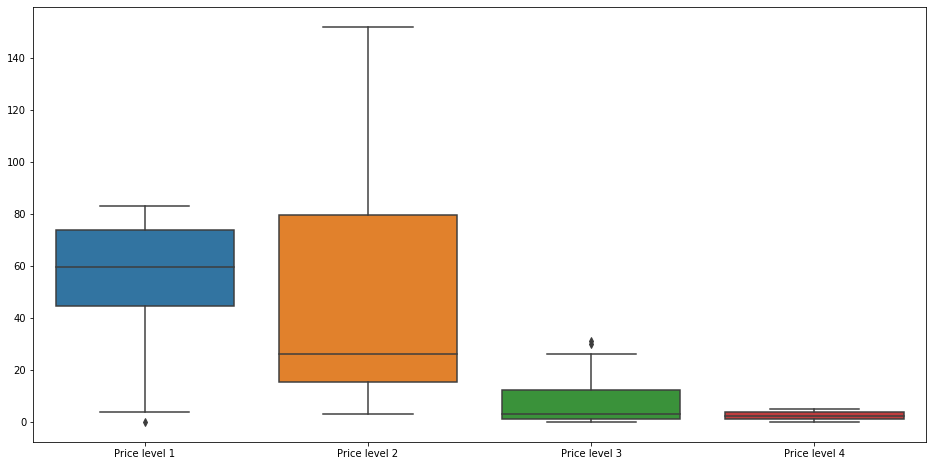

In [175]:
import seaborn as sns

import matplotlib.pyplot as plt
# use the inline backend to generate the plots within the browser
%matplotlib inline 

plt.figure(figsize=(16,8))

sns.boxplot(data=price_data)
plt.show

In [176]:
from sklearn.preprocessing import MinMaxScaler

In [177]:
scaled_price_data = MinMaxScaler().fit_transform(price_data)

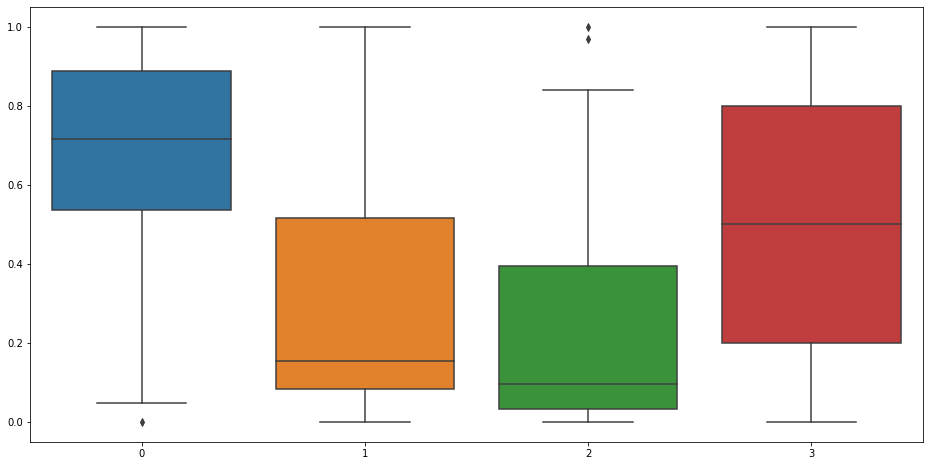

In [178]:
plt.figure(figsize=(16,8))
sns.boxplot(data=scaled_price_data)
plt.show()

In [195]:
#Time to create the clusters

k = 3

kmeans = KMeans(init="k-means++",n_clusters=k,n_init=12)
kmeans.fit(scaled_price_data)
kmeans.labels_[0:10]

array([0, 1, 0, 0, 2, 2, 0, 0, 2, 1], dtype=int32)

In [196]:
sp_boroughs["Cluster label"] = kmeans.labels_

In [197]:
sp_boroughs.head()

,Borough,Latitude,Longitude,Price level 1,Price level 2,Price level 3,Price level 4,Cluster label
0,Aricanduva,-23.578024,-46.511454,83,26,2,2,0
1,Butantã,-23.571900,-46.708090,70,116,18,0,1
2,Campo Limpo,-23.648880,-46.758729,82,38,3,3,0
3,Casa Verde,-23.505927,-46.656138,69,70,5,4,0
4,Cidade Ademar,-23.673012,-46.655281,47,15,2,1,2


In [198]:
# create map of Toronto using latitude and longitude values
map_sp_cluster = folium.Map(location=[sp_latitude, sp_longitude], zoom_start=11)

#Set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#Add markers to the map
markers_colors = []
for lat, lon, borough, cluster in zip(sp_boroughs['Latitude'], sp_boroughs['Longitude'], sp_boroughs['Borough'], sp_boroughs['Cluster label']):
    label = folium.Popup(borough + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_sp_cluster)
    
map_sp_cluster

Analysis of the returned clusters

In [215]:
scaled_price_data_df = pd.DataFrame(scaled_price_data)
scaled_price_data_df.columns = ["Price level 1","Price level 2","Price level 3","Price level 4"]
scaled_price_data_df["Cluster label"] = kmeans.labels_
scaled_price_data_df.head()

,Price level 1,Price level 2,Price level 3,Price level 4,Cluster label
0,1.000000,0.154362,0.064516,0.4,0
1,0.843373,0.758389,0.580645,0.0,1
2,0.987952,0.234899,0.096774,0.6,0
3,0.831325,0.449664,0.161290,0.8,0
4,0.566265,0.080537,0.064516,0.2,2


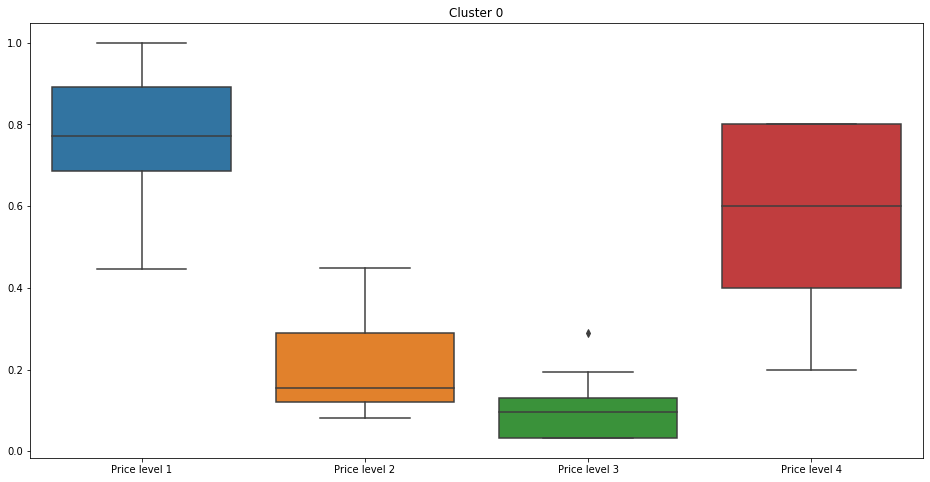

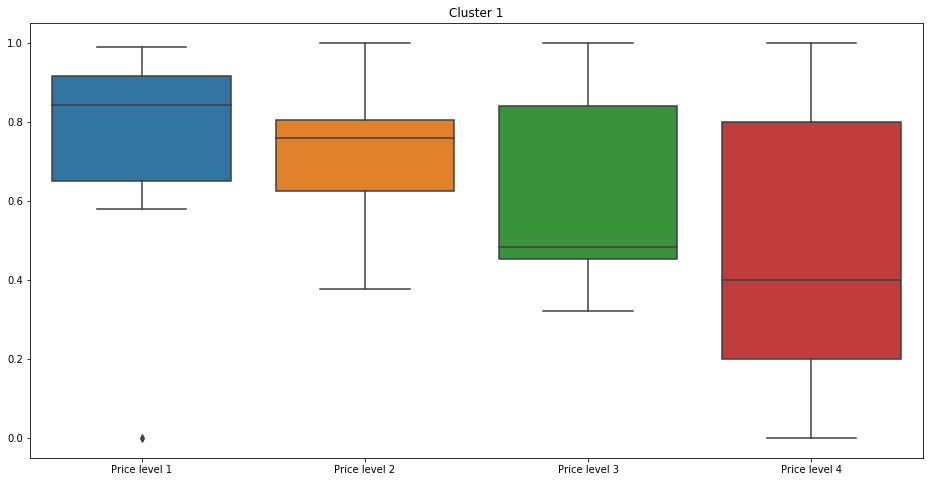

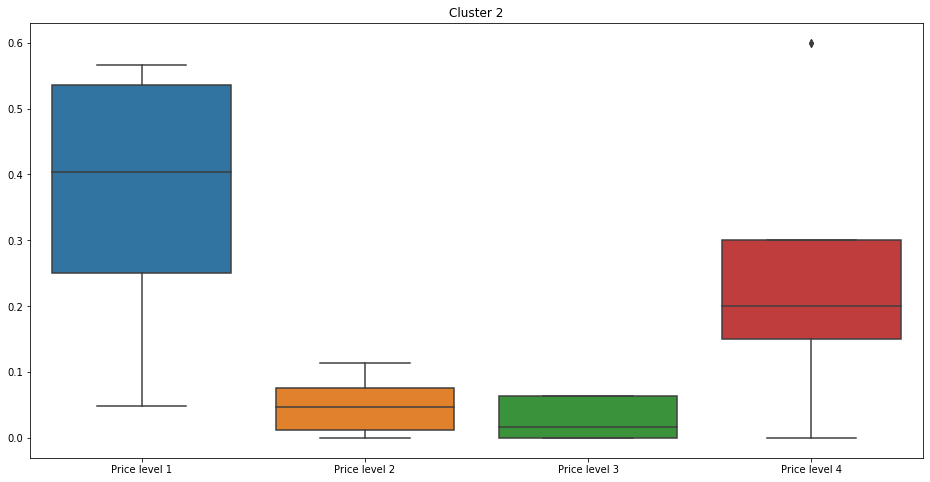

In [220]:
for i in range (k):
    plt.figure(figsize=(16,8))
    cluster_price_data=scaled_price_data_df.loc[scaled_price_data_df["Cluster label"] == i,:]
    ax = sns.boxplot(data=cluster_price_data.iloc[:,:-1])
    ax.set_title("Cluster " + str(i))
    plt.show()